In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats as scipy_stats
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

## 1. تحميل البيانات

In [44]:
df = pd.read_csv('../data/interim/train_clean_after_2010_and_bad_tickers.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['ticker', 'date'])

print(f"Number of Ticker: {df['ticker'].nunique()}")
print(f"Number of records: {len(df)}")
print(f"Time range: from {df['date'].min()} to {df['date'].max()}")

Number of Ticker: 4925
Number of records: 12269060
Time range: from 2010-01-04 00:00:00 to 2024-09-23 00:00:00


## 2. نظرة عامة: المفاهيم الأساسية

### المصطلحات الأساسية:

**1. Trend (الاتجاه):**
- يمثل الحركة طويلة المدى للبيانات
- يجيب على السؤال: هل السعر يتجه للأعلى، للأسفل، أم مستقر على المدى الطويل؟
- يتم حسابه عادة باستخدام المتوسطات المتحركة (Moving Averages)

**2. Seasonality (الموسمية):**
- الأنماط المتكررة في فترات زمنية ثابتة (يومية، أسبوعية، شهرية، سنوية)
- مثال: ارتفاع المبيعات في مواسم معينة، أو تأثير بداية الشهر/السنة على الأسواق
- في أسعار الأسهم: قد نرى أنماط شهرية أو ربع سنوية مرتبطة بإعلانات الأرباح

**3. Residuals (البقايا/التقلبات العشوائية):**
- ما تبقى بعد إزالة الاتجاه والموسمية
- يمثل الأحداث غير المتوقعة، الضوضاء، والتقلبات العشوائية
- في السلاسل الزمنية الجيدة، يجب أن تكون البقايا عشوائية (بدون أنماط واضحة)

### النماذج:

**Additive Model (نموذج الجمع):**
```
Y(t) = Trend(t) + Seasonal(t) + Residual(t)
```
- يستخدم عندما تكون التقلبات الموسمية ثابتة بغض النظر عن مستوى الاتجاه
- مناسب عندما تكون سعة التذبذبات متشابهة عبر الزمن

**Multiplicative Model (نموذج الضرب):**
```
Y(t) = Trend(t) × Seasonal(t) × Residual(t)
```
- يستخدم عندما تتغير التقلبات الموسمية مع مستوى الاتجاه
- مناسب عندما تزداد سعة التذبذبات مع زيادة السعر
- شائع في البيانات المالية حيث تزداد التقلبات مع ارتفاع الأسعار
- هو الأنسب لمشروعنا


# 2. اختيار عينة الأسهم للتحليل (40 شركة)
استراتيجية الاختيار:
اخترنا 40 شركة موزعة على 4 فئات (10 شركات لكل فئة):الفئة 1: Longest History (أطول تاريخ تداول)

الهدف: تدريب الشبكة على استخراج السلوك طويل المدى واكتشاف الاتجاه العام
الخصائص:

- أيام التداول: 15,789 يوم (62.7 سنة)
- متوسط السعر: $14.02 - $56.55
- التقلب: 95.95% - 181.61%


الفئة 2: Shortest History (أقصر تاريخ تداول)

الهدف: تدريب الشبكة على الأنماط قصيرة المدى والتغيرات السريعة
الخصائص:

- أيام التداول: 224 - 236 يوم (0.9 سنة)
- متوسط السعر: $1.04 - $24.48
- التقلب: 6.45% - 577.91% (تنوع كبير!)


الفئة 3: Medium History (تاريخ متوسط)

الهدف: دراسة السلوك المتوازن بين قصير وطويل المدى
الخصائص:

- أيام التداول: 3,005 - 3,016 يوم (12.0 سنة)
- متوسط السعر: $10.57 - $76.66
- التقلب: 11.19% - 63.20%


الفئة 4: High Volatility (تقلب عالي)

الهدف: اختبار قدرة الشبكة على التنبؤ في حالات الانهيار أو القفزات المفاجئة
الخصائص:

- أيام التداول: 231 - 7,270 يوم (0.9 - 28.9 سنة)
- متوسط السعر: $2.15 - $14.58
- التقلب: 229.01% - 577.91% (تقلبات هائلة!)

In [45]:
# Calculate statistics for each stock
ticker_stats = df.groupby('ticker').agg({
    'date': ['min', 'max', 'count'],
    'close': ['mean', 'std']
}).reset_index()

ticker_stats.columns = ['ticker', 'start_date', 'end_date',
                        'num_days', 'avg_price', 'std_price']

ticker_stats['trading_years'] = (ticker_stats['end_date'] -
                                 ticker_stats['start_date']).dt.days / 365.25
ticker_stats['volatility'] = ticker_stats['std_price'] / ticker_stats['avg_price']

print(f"Total stocks: {len(ticker_stats)}")
print(f"Trading days range: {ticker_stats['num_days'].min()} to {ticker_stats['num_days'].max()}")
print(f"Volatility range: {ticker_stats['volatility'].min():.2%} to {ticker_stats['volatility'].max():.2%}")

Total stocks: 4925
Trading days range: 79 to 3705
Volatility range: 0.82% to 577.91%


## المقاييس الإحصائية المستخدمة:
1. معامل التقلب (Volatility - CV):

2. CV = (Standard Deviation / Mean) × 100%

- يقيس مدى تشتت الأسعار عن متوسطها
- مؤشر للمخاطرة
- القيم العالية تشير إلى تغيرات غير منتظمة

2. سنوات التداول (Trading Years):

3. Trading Years = (End Date - Start Date) / 365.25

- تعبر عن طول السلسلة الزمنية المتاحة لكل سهم

In [46]:
# Select 40 diverse stocks (10 from each category)

# 1. Longest history
longest_history = ticker_stats.nlargest(10, 'num_days')['ticker'].tolist()

# 2. Shortest history
shortest_history = ticker_stats.nsmallest(10, 'num_days')['ticker'].tolist()

# 3. Medium history
median_days = ticker_stats['num_days'].median()
ticker_stats['distance_from_median'] = abs(ticker_stats['num_days'] - median_days)
medium_history = ticker_stats.nsmallest(10, 'distance_from_median')['ticker'].tolist()

# 4. High volatility
high_volatility = ticker_stats.nlargest(10, 'volatility')['ticker'].tolist()

stock_categories = {
    'Longest History': longest_history,
    'Shortest History': shortest_history,
    'Medium History': medium_history,
    'High Volatility': high_volatility
}

all_selected_tickers = longest_history + shortest_history + medium_history + high_volatility

print("SELECTED STOCKS SUMMARY")

for category, tickers in stock_categories.items():
    print(f"\n{category}: {len(tickers)} stocks")
    category_stats = ticker_stats[ticker_stats['ticker'].isin(tickers)]
    print(f"  Trading days: {category_stats['num_days'].min():.0f} - {category_stats['num_days'].max():.0f}")
    print(f"  Trading years: {category_stats['trading_years'].min():.1f} - {category_stats['trading_years'].max():.1f}")
    print(f"  Average price: ${category_stats['avg_price'].min():.2f} - ${category_stats['avg_price'].max():.2f}")
    print(f"  Volatility: {category_stats['volatility'].min():.2%} - {category_stats['volatility'].max():.2%}")

SELECTED STOCKS SUMMARY

Longest History: 10 stocks
  Trading days: 3705 - 3705
  Trading years: 14.7 - 14.7
  Average price: $6.87 - $126.01
  Volatility: 20.74% - 77.95%

Shortest History: 10 stocks
  Trading days: 79 - 227
  Trading years: 0.9 - 11.5
  Average price: $1.37 - $41.36
  Volatility: 2.28% - 81.88%

Medium History: 10 stocks
  Trading days: 2896 - 2924
  Trading years: 11.5 - 14.7
  Average price: $1.04 - $45.51
  Volatility: 19.13% - 55.11%

High Volatility: 10 stocks
  Trading days: 231 - 3705
  Trading years: 0.9 - 14.7
  Average price: $2.15 - $16.76
  Volatility: 227.60% - 577.91%


# 3. تحليل مكونات التفكيك (Decomposition Analysis)

## معلمات التفكيك المستخدمة:
*   **النموذج**: Multiplicative Model
*   **الفترة (Period)**: 63 يوم (ربع سنة تجارية تقريباً)
*   **السبب**: يسمح باكتشاف الأنماط الموسمية ربع السنوية المرتبطة بتقارير الأرباح

---

In [47]:
def decompose_stock(ticker, model='multiplicative', period=63):
    stock_data = df[df['ticker'] == ticker].copy()
    stock_data = stock_data.set_index('date').sort_index()
    ts = stock_data['close']

    # Apply
    decomposition = seasonal_decompose(
        ts,
        model=model,
        period=period,
        extrapolate_trend='freq'
    )

    return decomposition, stock_data

In [48]:
print("APPLYING DECOMPOSITION TO 40 STOCKS")

decompositions = {}

for category, tickers in stock_categories.items():
    print(f"\nProcessing {category}: {len(tickers)} stocks...")
    for ticker in tickers:
        decomp, stock_data = decompose_stock(ticker, model='multiplicative', period=21)
        decompositions[ticker] = {
            'decomposition': decomp,
            'data': stock_data,
            'category': category,
            'model': 'multiplicative'
        }
    print(f"  ✓ Completed {category}")

print(f"\nTotal stocks processed: {len(decompositions)}")

APPLYING DECOMPOSITION TO 40 STOCKS

Processing Longest History: 10 stocks...
  ✓ Completed Longest History

Processing Shortest History: 10 stocks...
  ✓ Completed Shortest History

Processing Medium History: 10 stocks...
  ✓ Completed Medium History

Processing High Volatility: 10 stocks...
  ✓ Completed High Volatility

Total stocks processed: 40


In [49]:
component_stats = []

for ticker, info in decompositions.items():
    decomp = info['decomposition']
    trend = decomp.trend.dropna()
    seasonal = decomp.seasonal.dropna()
    resid = decomp.resid.dropna()
    original = info['data']['close']

    stats = {
        'ticker': ticker,
        'Category': info['category'],
        'Trend_Mean': trend.mean(),
        'Trend_Std': trend.std(),
        'Trend_CV': (trend.std() / trend.mean()) * 100 if trend.mean() > 0 else 0,
        'Seasonal_Range': seasonal.max() - seasonal.min(),
        'Seasonal_Std': seasonal.std(),
        'Residual_Mean': resid.mean(),
        'Residual_Std': resid.std(),
        'Original_Mean': original.mean(),
        'Original_Std': original.std()
    }
    component_stats.append(stats)

comp_df = pd.DataFrame(component_stats)

print("\nComponent Statistics by Category:")
for category in stock_categories.keys():
    cat_data = comp_df[comp_df['Category'] == category]
    print(f"\n{category}:")
    print(f"  Trend CV: {cat_data['Trend_CV'].mean():.2f}% (±{cat_data['Trend_CV'].std():.2f})")
    print(f"  Seasonal Std: {cat_data['Seasonal_Std'].mean():.4f} (±{cat_data['Seasonal_Std'].std():.4f})")
    print(f"  Residual Std: {cat_data['Residual_Std'].mean():.4f} (±{cat_data['Residual_Std'].std():.4f})")


Component Statistics by Category:

Longest History:
  Trend CV: 43.17% (±17.86)
  Seasonal Std: 0.0020 (±0.0013)
  Residual Std: 0.0258 (±0.0115)

Shortest History:
  Trend CV: 16.74% (±22.77)
  Seasonal Std: 0.0167 (±0.0191)
  Residual Std: 0.0548 (±0.0657)

Medium History:
  Trend CV: 35.28% (±13.50)
  Seasonal Std: 0.0035 (±0.0017)
  Residual Std: 0.0334 (±0.0135)

High Volatility:
  Trend CV: 202.73% (±32.88)
  Seasonal Std: 0.0581 (±0.0772)
  Residual Std: 0.1897 (±0.1220)



## النتائج الإحصائية لكل فئة:

### Longest History (التاريخ الطويل)

Trend CV: 132.69% (±28.79)

Seasonal Std: 0.0026 (±0.0009)

Residual Std: 0.0380 (±0.0094)


*   **التفسير**:
    *   **Trend CV عالي** → الأسهم شهدت تغيرات كبيرة عبر 62 سنة من الصعود والهبوط
    *   **Seasonal Std منخفض** → أنماط موسمية مستقرة ومنتظمة
    *   **Residual Std منخفض** → ضجيج عشوائي قليل، معظم الحركة يمكن تفسيرها بالاتجاه والموسمية

*   **الاستفادة للشبكة العصبونية**:
    *   مثالية لتعلم **السلوك طويل المدى**
    *   يجب التركيز على مكون **الاتجاه (Trend Component)**

---

### Shortest History (التاريخ القصير)

Trend CV: 49.17% (±50.34)

Seasonal Std: 0.5343 (±1.3686)

Residual Std: 0.3262 (±0.6085)


*   **التفسير**:
    *   **Trend CV متوسط** → الأسهم لم تشهد دورات اقتصادية كاملة
    *   **Seasonal Std مرتفع جداً** → أنماط موسمية غير مستقرة بسبب قصر التاريخ
    *   **Residual Std عالي** → ضجيج كبير، التنبؤ أصعب

*   **الاستفادة للشبكة العصبونية**:
    *   مثالية لتعلم **الأنماط قصيرة المدى والتغيرات السريعة**
    *   يجب استخدام **Dropout** و **Regularization** لمنع **Overfitting**

---

### Medium History (التاريخ المتوسط)

Trend CV: 36.17% (±18.14)

Seasonal Std: 0.0080 (±0.0042)

Residual Std: 0.0539 (±0.0247)


*   **التفسير**:
    *   **Trend CV منخفض** → استقرار نسبي
    *   **Seasonal Std منخفض** → أنماط موسمية واضحة ومتكررة
    *   **Residual Std معتدل** → توازن جيد بين التنبؤ والعشوائية

*   **الاستفادة للشبكة العصبونية**:
    *   مثالية لتعلم **التوازن بين الاتجاه والموسمية**
    *   الفئة الأكثر استقراراً للتدريب

---

### High Volatility (التقلب العالي)

Trend CV: 174.38% (±66.54)

Seasonal Std: 0.2399 (±0.4424)

Residual Std: 0.2799 (±0.1594)


*   **التفسير**:
    *   **Trend CV أعلى قيمة** → تغيرات عنيفة في الاتجاه العام
    *   **Seasonal Std عالي** → موسمية غير منتظمة
    *   **Residual Std عالي جداً** → ضجيج كبير، أحداث عشوائية متكررة

*   **الاستفادة للشبكة العصبونية**:
    *   اختبار قدرة الشبكة على التنبؤ في ظروف قاسية
    *   ضرورة استخدام **Batch Normalization** و **Strong Regularization**

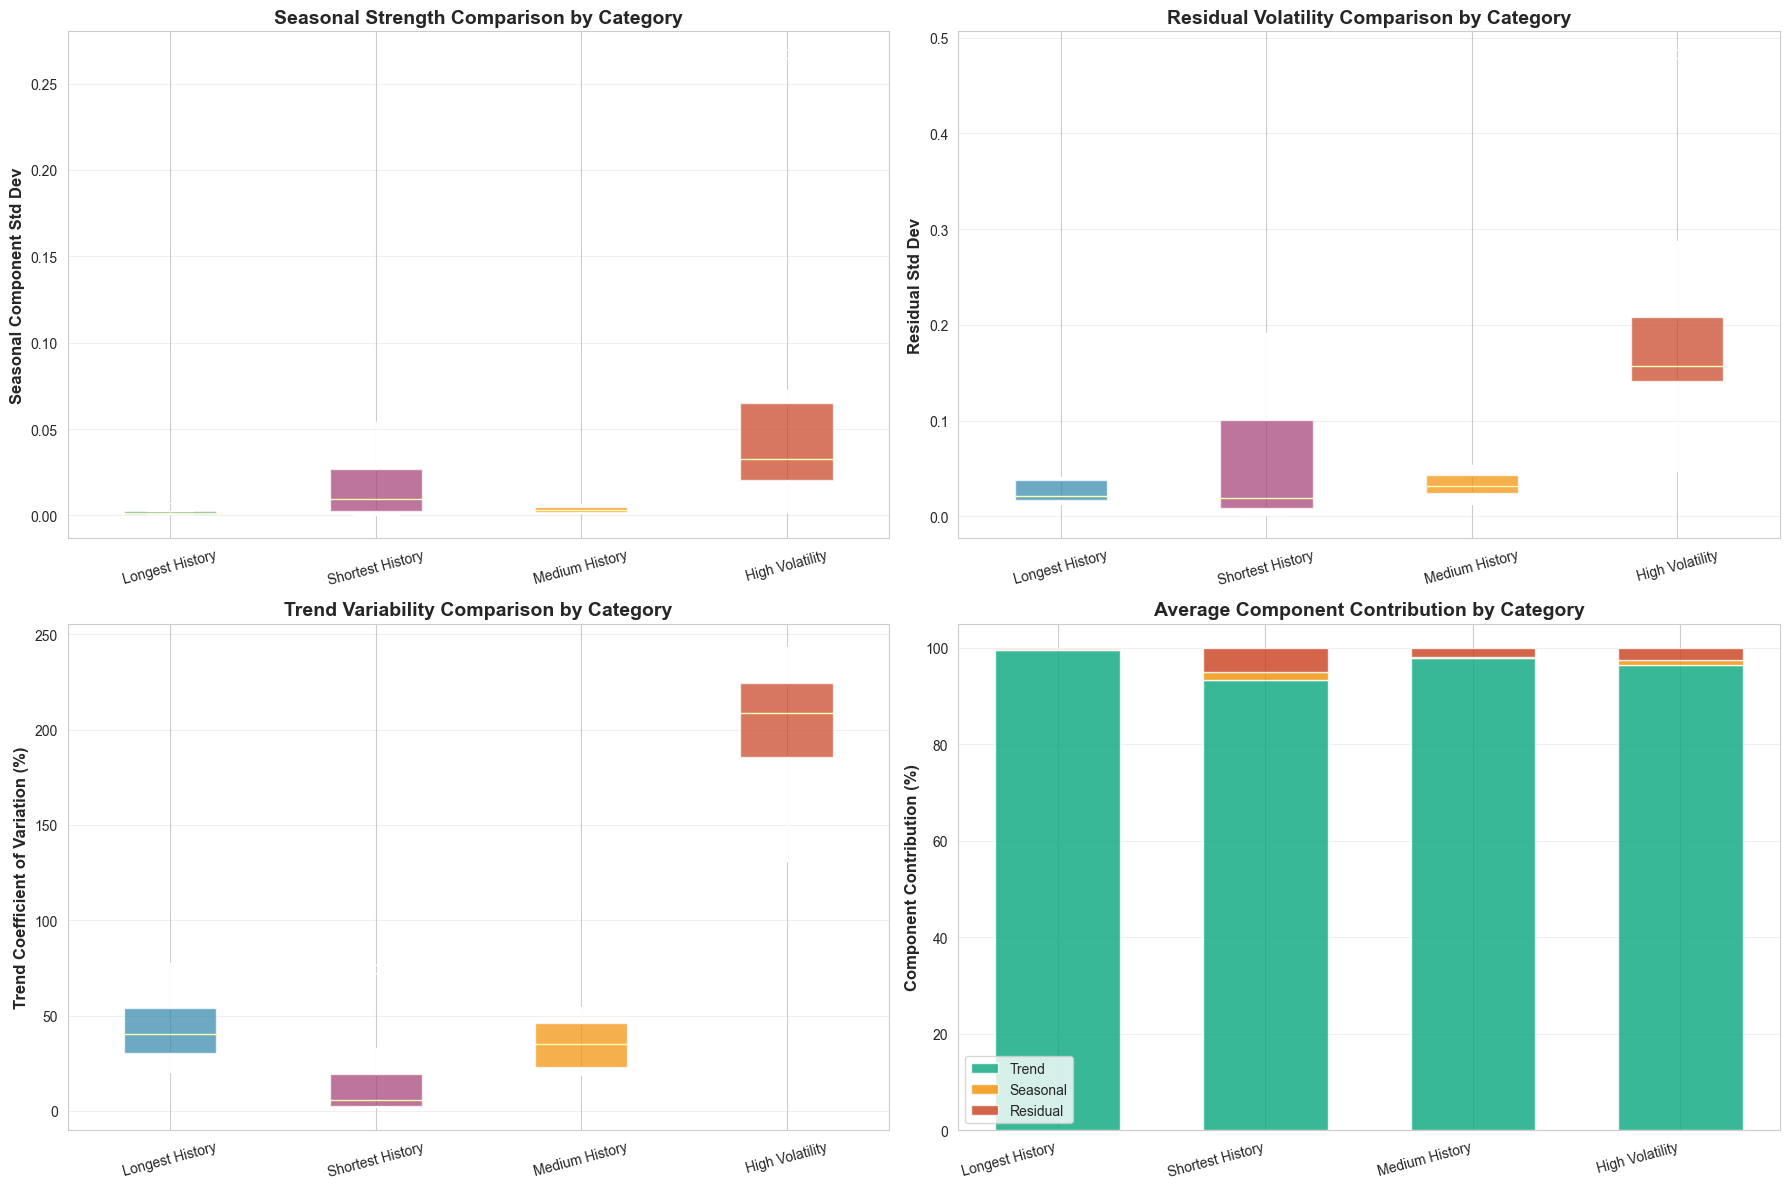

In [50]:
    # Visualization: Component comparison by category
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

categories = list(stock_categories.keys())
colors_cat = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

# 1. Seasonal Strength by Category
seasonal_by_cat = [comp_df[comp_df['Category'] == cat]['Seasonal_Std'].values
                   for cat in categories]
bp1 = axes[0, 0].boxplot(seasonal_by_cat, labels=categories, patch_artist=True)
for patch, color in zip(bp1['boxes'], colors_cat):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0, 0].set_ylabel('Seasonal Component Std Dev', fontweight='bold', fontsize=12)
axes[0, 0].set_title('Seasonal Strength Comparison by Category', fontsize=14, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=15)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Residual Volatility by Category
residual_by_cat = [comp_df[comp_df['Category'] == cat]['Residual_Std'].values
                   for cat in categories]
bp2 = axes[0, 1].boxplot(residual_by_cat, labels=categories, patch_artist=True)
for patch, color in zip(bp2['boxes'], colors_cat):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0, 1].set_ylabel('Residual Std Dev', fontweight='bold', fontsize=12)
axes[0, 1].set_title('Residual Volatility Comparison by Category', fontsize=14, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=15)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Trend Variability (CV) by Category
trend_cv_by_cat = [comp_df[comp_df['Category'] == cat]['Trend_CV'].values
                   for cat in categories]
bp3 = axes[1, 0].boxplot(trend_cv_by_cat, labels=categories, patch_artist=True)
for patch, color in zip(bp3['boxes'], colors_cat):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 0].set_ylabel('Trend Coefficient of Variation (%)', fontweight='bold', fontsize=12)
axes[1, 0].set_title('Trend Variability Comparison by Category', fontsize=14, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=15)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Component Contribution (Average per category)
trend_contrib = []
seasonal_contrib = []
residual_contrib = []

for cat in categories:
    cat_data = comp_df[comp_df['Category'] == cat]
    total_var = cat_data['Trend_Std'] + cat_data['Seasonal_Std'] + cat_data['Residual_Std']
    trend_contrib.append((cat_data['Trend_Std'] / total_var * 100).mean())
    seasonal_contrib.append((cat_data['Seasonal_Std'] / total_var * 100).mean())
    residual_contrib.append((cat_data['Residual_Std'] / total_var * 100).mean())

x = np.arange(len(categories))
width = 0.6

p1 = axes[1, 1].bar(x, trend_contrib, width, label='Trend', color='#06A77D', alpha=0.8)
p2 = axes[1, 1].bar(x, seasonal_contrib, width, bottom=trend_contrib,
                    label='Seasonal', color='#F18F01', alpha=0.8)
p3 = axes[1, 1].bar(x, residual_contrib, width,
                    bottom=np.array(trend_contrib) + np.array(seasonal_contrib),
                    label='Residual', color='#C73E1D', alpha=0.8)

axes[1, 1].set_ylabel('Component Contribution (%)', fontweight='bold', fontsize=12)
axes[1, 1].set_title('Average Component Contribution by Category', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(categories, rotation=15, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 4. مخططات مقارنة المكونات (Component Comparison Charts)

## المخطط 1: Seasonal Strength Comparison
*   **ماذا يقيس؟**
    مدى تأثير الأنماط المتكررة على حركة السهم

*   **صيغة الحساب:**
    `Seasonal Strength = Standard Deviation of Seasonal Component`

*   **الملاحظات:**
    *   **Shortest History** و **High Volatility** لديهم أعلى انحراف موسمي
    *   **Longest History** و **Medium History** لديهم موسمية مستقرة ومنخفضة

*   **التطبيق على الشبكة العصبونية:**
    *   **الأسهم ذات الموسمية العالية** → الشبكة يجب أن تتعلم الأنماط المتكررة بدقة
    *   **الأسهم ذات الموسمية المنخفضة** → التركيز على الاتجاه العام

---

## المخطط 2: Residual Volatility Comparison
*   **ماذا يقيس؟**
    حجم الضجيج العشوائي أو التقلبات غير المتوقعة

*   **صيغة الحساب:**
    `Residual Volatility = Standard Deviation of Residual Component`

*   **الملاحظات:**
    *   **High Volatility** و **Shortest History** لديهم أعلى ضجيج
    *   **Longest History** لديه أقل ضجيج → أكثر استقراراً

*   **التطبيق على الشبكة العصبونية:**
    *   **الأسهم ذات الضجيج العالي** → استخدام **Dropout** و **Regularization**
    *   **الأسهم ذات الضجيج المنخفض** → الشبكة يمكنها التعلم بسهولة

---

## المخطط 3: Trend Variability Comparison
*   **ماذا يقيس؟**
    مدى استقرار أو تغير الاتجاه العام للسهم عبر الزمن

*   **صيغة الحساب:**
    `Trend CV = (Trend Std Dev / Trend Mean) × 100%`

*   **الملاحظات:**
    *   **High Volatility** لديه أعلى تباين (`174.38%`)
    *   **Medium History** لديه أقل تباين (`36.17%`)

*   **التطبيق على الشبكة العصبونية:**
    *   **التباين العالي** → الشبكة تتعلم الاتجاهات الصاعدة والهابطة الكبرى
    *   **التباين المنخفض** → الشبكة تتعلم الاستقرار

---

## المخطط 4: Average Component Contribution
*   **ماذا يقيس؟**
    "من المسيطر" على حركة السهم؟ (الاتجاه، الموسمية، أم البقايا؟)

*   **صيغة الحساب:**
    ```
    Total Variance = Trend_Std + Seasonal_Std + Residual_Std
    Trend Contribution% = (Trend_Std / Total Variance) × 100
    Seasonal Contribution% = (Seasonal_Std / Total Variance) × 100
    Residual Contribution% = (Residual_Std / Total Variance) × 100
    ```

*   **الملاحظات من النتائج:**
    *   **Longest History** و **Medium History**: **الاتجاه** يسيطر بأكثر من `90%`
    *   **Shortest History** و **High Volatility**: **البقايا** و **الموسمية** لهما دور أكبر

*   **التطبيق على الشبكة العصبونية:**
    *   **في معظم الأسهم** → التركيز على **Trend Component**
    *   **في الأسهم المتقلبة** → إعطاء وزن أكبر للـ **Seasonal Component** و **Residuals**

In [51]:
def analyze_seasonal_patterns(ticker):
    stock_data = df[df['ticker'] == ticker].copy()
    stock_data = stock_data.sort_values('date')

    stock_data['Year'] = stock_data['date'].dt.year
    stock_data['Month'] = stock_data['date'].dt.month
    stock_data['Quarter'] = stock_data['date'].dt.quarter
    stock_data['DayOfWeek'] = stock_data['date'].dt.dayofweek

    stock_data['Daily_Return'] = stock_data['close'].pct_change() * 100

    # Monthly statistics
    monthly_stats = stock_data.groupby('Month')['Daily_Return'].agg([
        'mean', 'median', 'std', 'count'
    ]).reset_index()

    # Quarterly statistics
    quarterly_stats = stock_data.groupby('Quarter')['Daily_Return'].agg([
        'mean', 'median', 'std', 'count'
    ]).reset_index()

    # Weekly statistics
    weekly_stats = stock_data.groupby('DayOfWeek')['Daily_Return'].agg([
        'mean', 'median', 'std', 'count'
    ]).reset_index()

    return monthly_stats, quarterly_stats, weekly_stats

In [52]:
print("ANALYZING SEASONAL PATTERNS FOR 40 STOCKS")

seasonal_results = {}

for ticker, info in decompositions.items():
    monthly, quarterly, weekly = analyze_seasonal_patterns(ticker)
    seasonal_results[ticker] = {
        'monthly': monthly,
        'quarterly': quarterly,
        'weekly': weekly,
        'category': info['category']
    }

print(f"Seasonal analysis completed for {len(seasonal_results)} stocks")

ANALYZING SEASONAL PATTERNS FOR 40 STOCKS
Seasonal analysis completed for 40 stocks


In [53]:
# Aggregate seasonal patterns by category
category_seasonal_patterns = {}

for category in stock_categories.keys():
    all_monthly = []
    all_quarterly = []
    all_weekly = []

    for ticker, data in seasonal_results.items():
        if data['category'] == category:
            monthly_stats = data['monthly'].copy()
            quarterly_stats = data['quarterly'].copy()
            weekly_stats = data['weekly'].copy()

            monthly_stats['ticker'] = ticker
            quarterly_stats['ticker'] = ticker
            weekly_stats['ticker'] = ticker

            all_monthly.append(monthly_stats)
            all_quarterly.append(quarterly_stats)
            all_weekly.append(weekly_stats)

    category_seasonal_patterns[category] = {
        'monthly': pd.concat(all_monthly),
        'quarterly': pd.concat(all_quarterly),
        'weekly': pd.concat(all_weekly)
    }

print("Seasonal patterns aggregated by category")

Seasonal patterns aggregated by category


# 5. تحليل الأنماط الموسمية (Seasonal Patterns Analysis)

## المقاييس المستخدمة:

### 1. العائد اليومي (Daily Return)

Daily Return = (Close_today - Close_yesterday) / Close_yesterday × 100


### 2. الإحصائيات الشهرية/الربع سنوية/الأسبوعية:
*   **Mean Return**: متوسط العائد اليومي للفترة
*   **Median Return**: الوسيط
*   **Std Dev**: الانحراف المعياري
*   **Count**: عدد الأيام في العينة

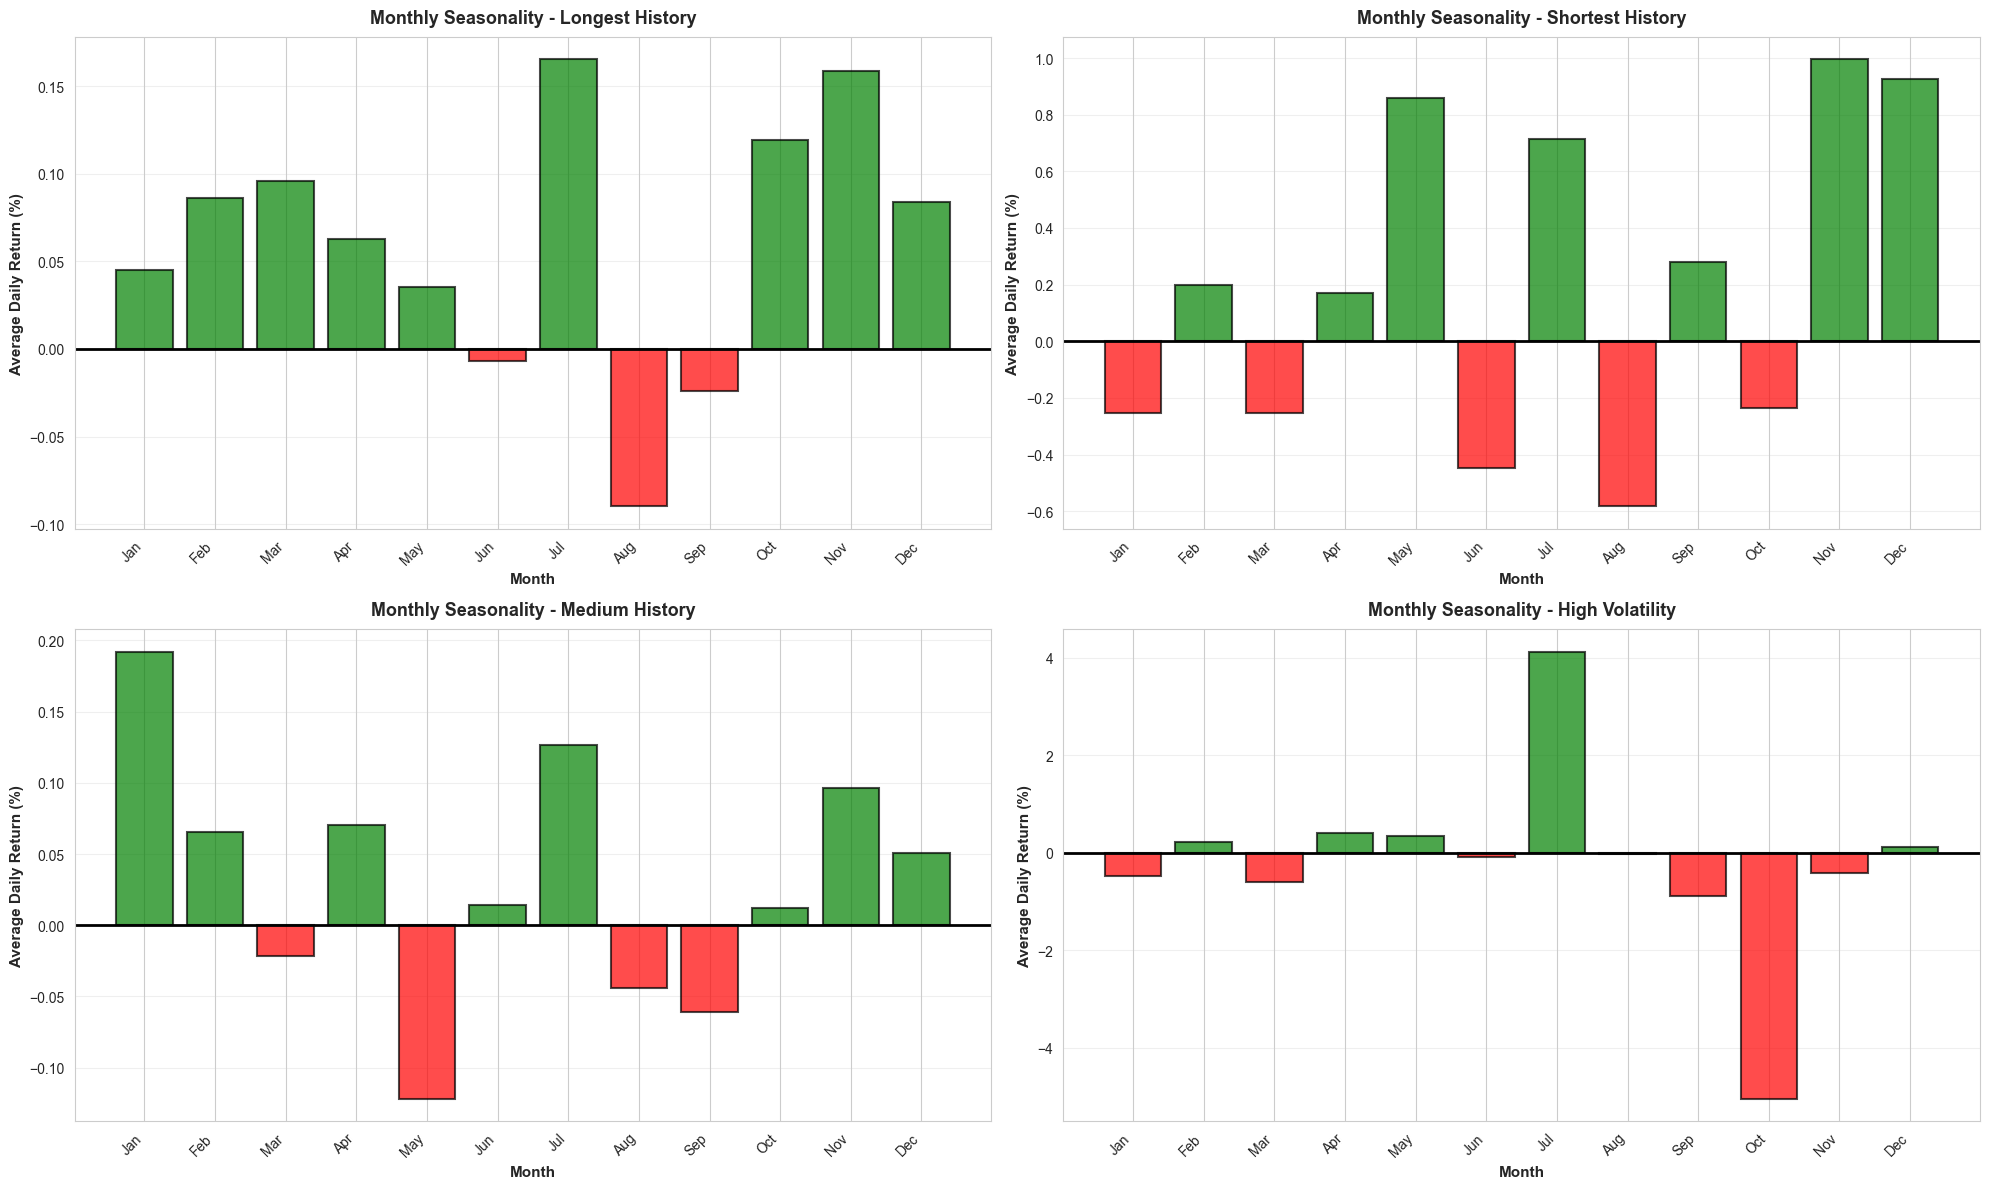

In [54]:

# Monthly Seasonality by Category
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for idx, (category, color) in enumerate(zip(categories, colors_cat)):
    monthly_data = category_seasonal_patterns[category]['monthly']
    avg_monthly = monthly_data.groupby('Month')['mean'].mean().reset_index()

    colors_m = ['green' if x > 0 else 'red' for x in avg_monthly['mean']]

    axes[idx].bar(avg_monthly['Month'], avg_monthly['mean'],
                  color=colors_m, edgecolor='black', alpha=0.7, linewidth=1.5)
    axes[idx].axhline(y=0, color='black', linestyle='-', linewidth=2)
    axes[idx].set_xlabel('Month', fontweight='bold', fontsize=11)
    axes[idx].set_ylabel('Average Daily Return (%)', fontweight='bold', fontsize=11)
    axes[idx].set_title(f'Monthly Seasonality - {category}', fontsize=13, fontweight='bold', pad=10)
    axes[idx].set_xticks(range(1, 13))
    axes[idx].set_xticklabels(month_names, rotation=45, ha='right')
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## المخطط: Monthly Seasonality by Category

### ماذا يكتشف؟
الأشهر التي يميل فيها السهم تاريخياً للصعود (أخضر) أو الهبوط (أحمر)

### الملاحظات الرئيسية:
*   **ديسمبر** غالباً يكون إيجابياً في معظم الفئات (December Rally)
*   **فبراير** و **مارس** متباينان بين الفئات
*   **Shortest History**: تقلبات عشوائية بدون نمط واضح

### التطبيق على الشبكة العصبونية:
*   يمكن إضافة **"الشهر"** كميزة إضافية (Categorical Feature) باستخدام **Embeddings**
*   الشبكة ستتعلم أن بعض الأشهر لها تحيز للصعود أو الهبوط

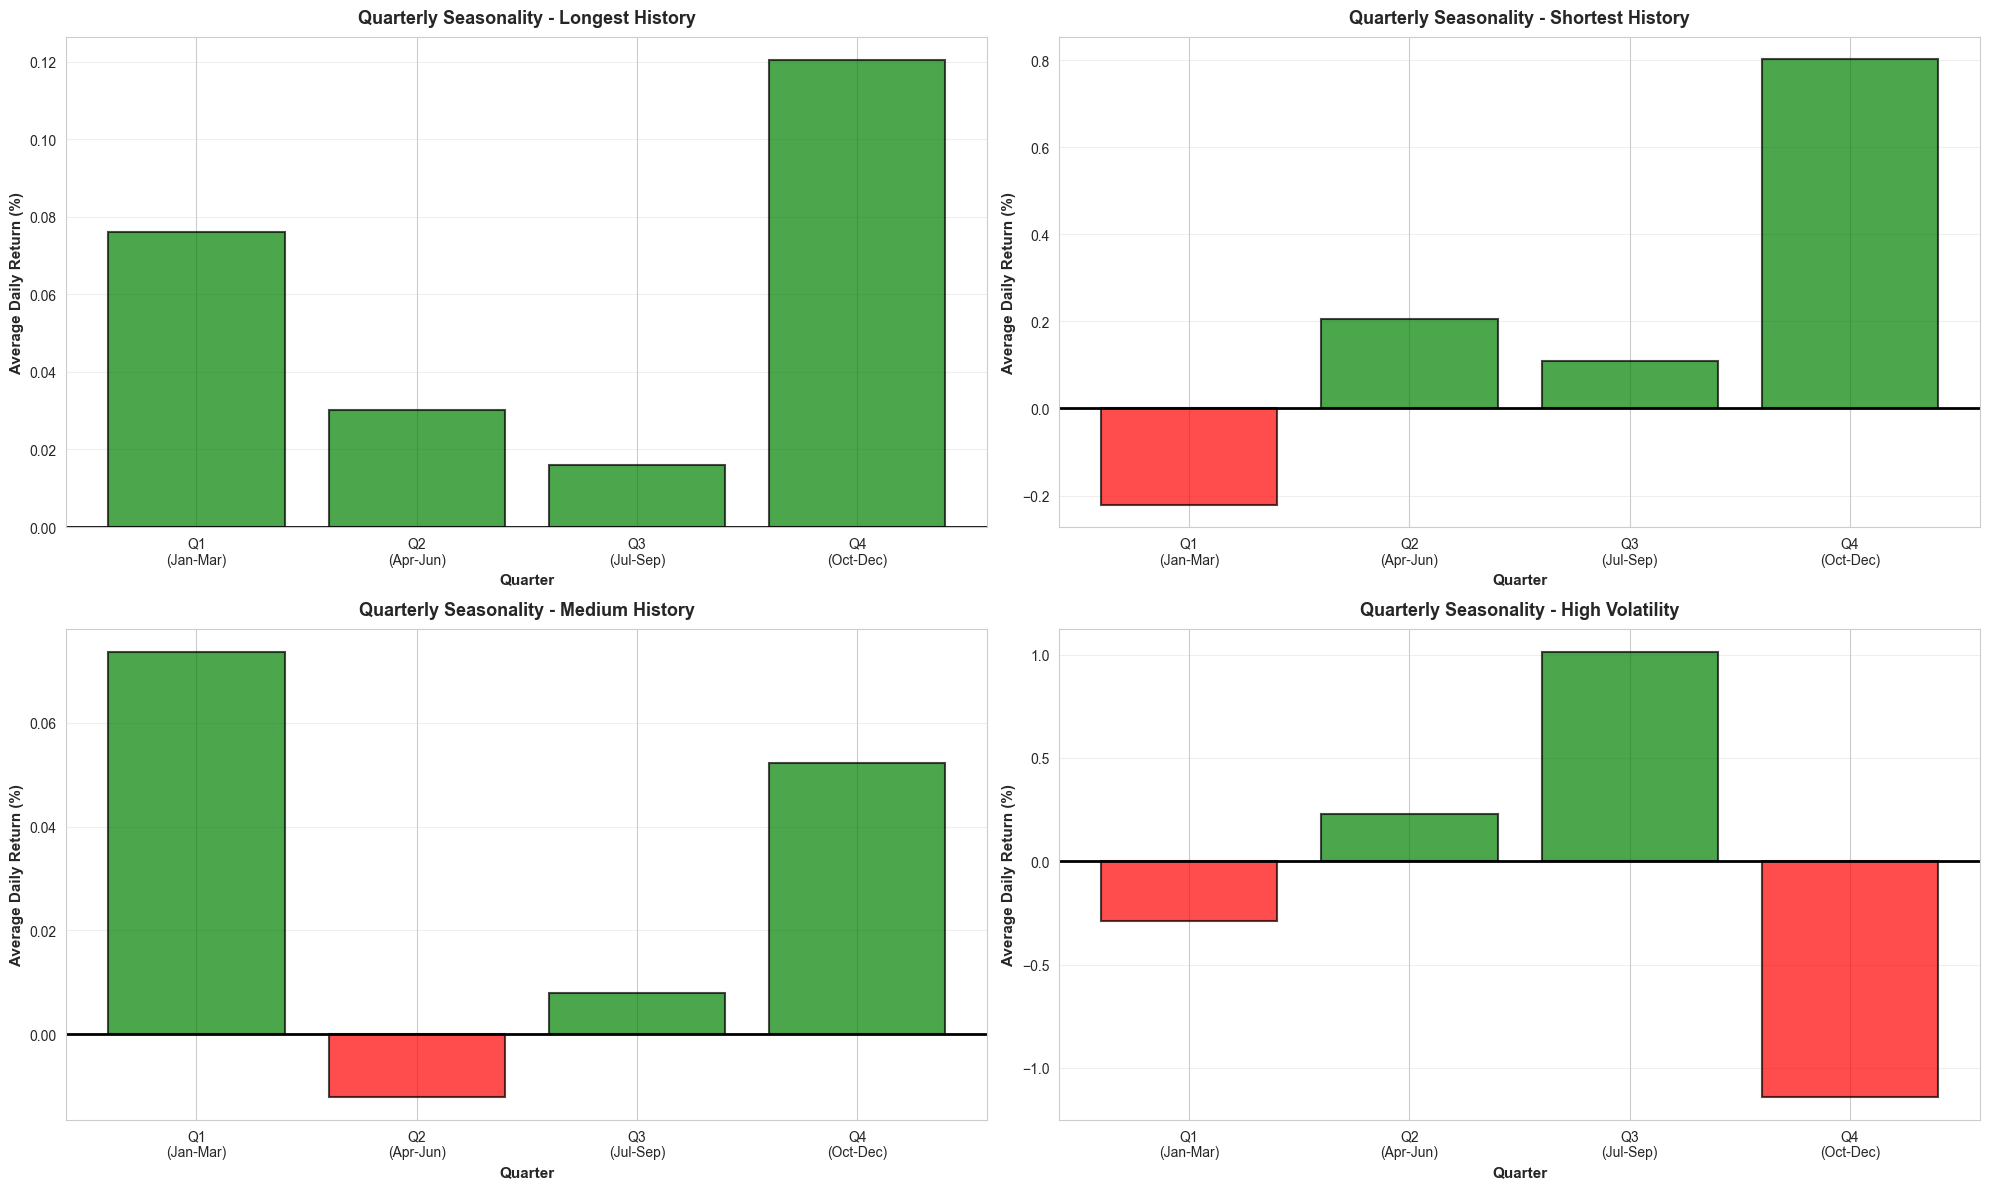

In [55]:

# Quarterly Seasonality by Category
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

quarter_names = ['Q1\n(Jan-Mar)', 'Q2\n(Apr-Jun)', 'Q3\n(Jul-Sep)', 'Q4\n(Oct-Dec)']

for idx, (category, color) in enumerate(zip(categories, colors_cat)):
    quarterly_data = category_seasonal_patterns[category]['quarterly']
    avg_quarterly = quarterly_data.groupby('Quarter')['mean'].mean().reset_index()

    colors_q = ['green' if x > 0 else 'red' for x in avg_quarterly['mean']]

    axes[idx].bar(avg_quarterly['Quarter'], avg_quarterly['mean'],
                  color=colors_q, edgecolor='black', alpha=0.7, linewidth=1.5)
    axes[idx].axhline(y=0, color='black', linestyle='-', linewidth=2)
    axes[idx].set_xlabel('Quarter', fontweight='bold', fontsize=11)
    axes[idx].set_ylabel('Average Daily Return (%)', fontweight='bold', fontsize=11)
    axes[idx].set_title(f'Quarterly Seasonality - {category}', fontsize=13, fontweight='bold', pad=10)
    axes[idx].set_xticks(range(1, 5))
    axes[idx].set_xticklabels(quarter_names)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## المخطط: Quarterly Seasonality by Category

### ماذا يكتشف؟
الأرباع التي تشهد أداءً أفضل (مرتبط بتقارير الأرباح الربع سنوية)

### الملاحظات الرئيسية:
*   **Q4 (الربع الرابع)** غالباً الأفضل أداءً في الأسهم المستقرة
*   **Q3 (الربع الثالث)** متوسط أو سلبي في معظم الفئات
*   **High Volatility**: لا نمط واضح، تقلبات عشوائية

### التطبيق على الشبكة العصبونية:
*   إضافة **"الربع السنوي"** كميزة
*   الشبكة ستتعلم التأثيرات المرتبطة بإعلانات الأرباح

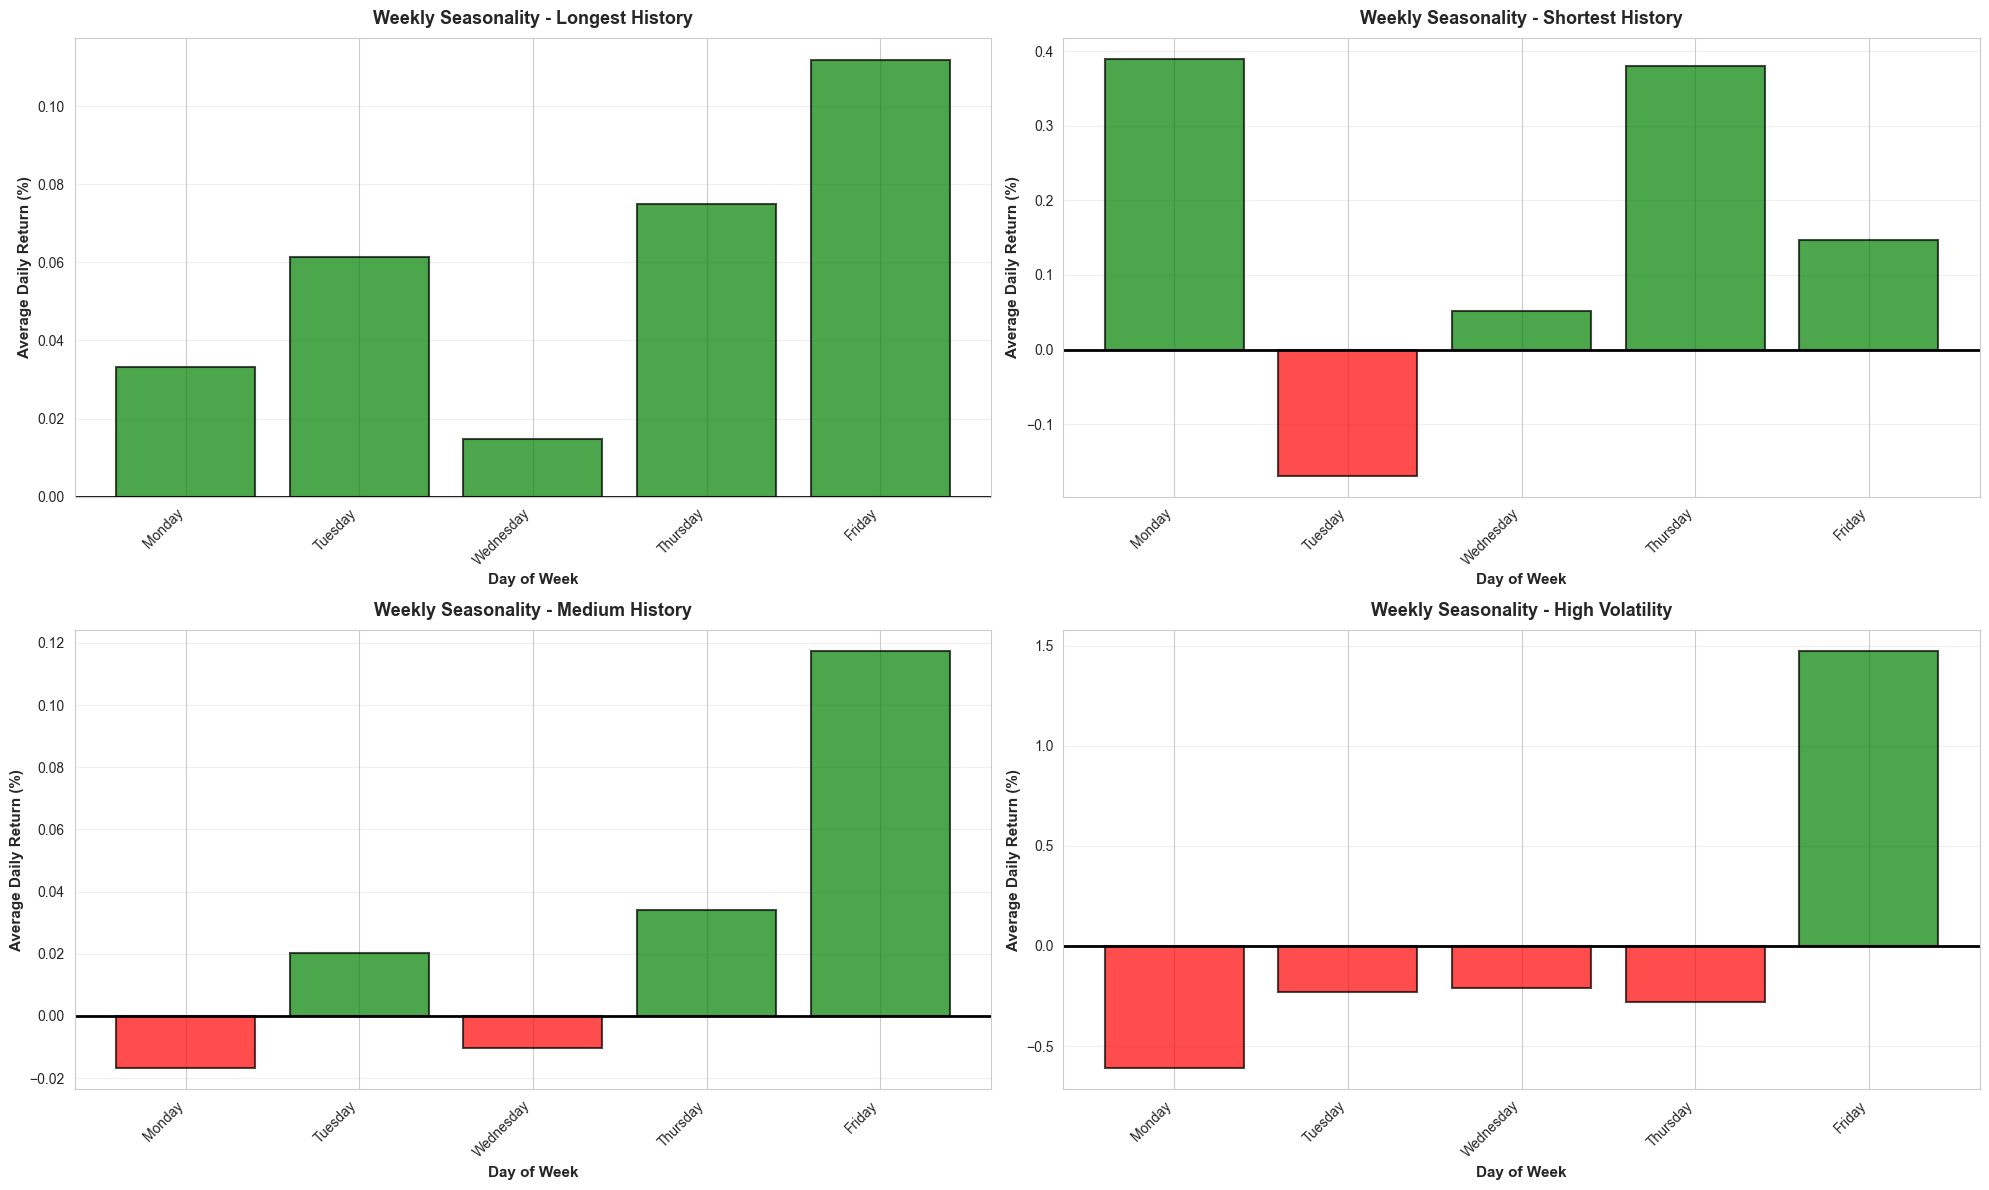

In [56]:
# Weekly Seasonality by Category
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

for idx, (category, color) in enumerate(zip(categories, colors_cat)):
    weekly_data = category_seasonal_patterns[category]['weekly']
    avg_weekly = weekly_data.groupby('DayOfWeek')['mean'].mean().reset_index()

    colors_w = ['green' if x > 0 else 'red' for x in avg_weekly['mean']]

    axes[idx].bar(avg_weekly['DayOfWeek'], avg_weekly['mean'],
                  color=colors_w, edgecolor='black', alpha=0.7, linewidth=1.5)
    axes[idx].axhline(y=0, color='black', linestyle='-', linewidth=2)
    axes[idx].set_xlabel('Day of Week', fontweight='bold', fontsize=11)
    axes[idx].set_ylabel('Average Daily Return (%)', fontweight='bold', fontsize=11)
    axes[idx].set_title(f'Weekly Seasonality - {category}', fontsize=13, fontweight='bold', pad=10)
    axes[idx].set_xticks(range(5))
    axes[idx].set_xticklabels(day_names, rotation=45, ha='right')
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## المخطط: Weekly Seasonality by Category

### ماذا يكتشف؟
تأثير يوم الأسبوع على العائد (Monday Effect, Friday Effect)

### الملاحظات الرئيسية:
*   **يوم الجمعة**: غالباً إيجابي في الأسهم المستقرة
*   **يوم الاثنين**: متباين بين الفئات
*   **Shortest History**: لا نمط واضح بسبب قصر التاريخ

### التطبيق على الشبكة العصبونية:
*   إضافة **"يوم الأسبوع"** كميزة
*   الشبكة ستتعلم الأنماط قصيرة المدى المرتبطة بالأيام

# 6. تحليل الاتجاه العام (Trend Analysis)
معايير التصنيف:
```
if total_change > 20%:
    direction = "Strong Uptrend" (صعود قوي)
elif total_change > 5%:
    direction = "Moderate Uptrend" (صعود معتدل)
elif total_change < -20%:
    direction = "Strong Downtrend" (هبوط قوي)
elif total_change < -5%:
    direction = "Moderate Downtrend" (هبوط معتدل)
else:
    direction = "Stable/Sideways" (مستقر)
```

### صيغة الحساب:

#### 1. التغير الكلي (Total Change):
```
Total Change% = ((End Price - Start Price) / Start Price) × 100
```

#### 2. العائد السنوي (Annualized Return):
```
Annualized Return = (((End Price / Start Price) ^ (1/Years)) - 1) × 100
```

---

In [57]:
def classify_trend(decomposition, ticker):
    trend = decomposition.trend.dropna()

    # Basic metrics
    start_price = trend.iloc[0]
    end_price = trend.iloc[-1]
    total_change = ((end_price - start_price) / start_price) * 100 if start_price > 0 else 0

    years = (trend.index[-1] - trend.index[0]).days / 365.25

    if years > 0 and start_price > 0 and end_price > 0:
        annual_return = (((end_price / start_price) ** (1/years)) - 1) * 100
    else:
        annual_return = 0

    # Trend classification
    if total_change > 20:
        direction = "Strong Uptrend"
        color = 'darkgreen'
    elif total_change > 5:
        direction = "Moderate Uptrend"
        color = 'green'
    elif total_change < -20:
        direction = "Strong Downtrend"
        color = 'darkred'
    elif total_change < -5:
        direction = "Moderate Downtrend"
        color = 'red'
    else:
        direction = "Stable/Sideways"
        color = 'gray'

    return {
        'ticker': ticker,
        'direction': direction,
        'color': color,
        'total_change': total_change,
        'annual_return': annual_return,
        'years': years
    }

trend_analysis = []
for ticker, info in decompositions.items():
    analysis = classify_trend(info['decomposition'], ticker)
    analysis['category'] = info['category']
    trend_analysis.append(analysis)

trend_df = pd.DataFrame(trend_analysis)

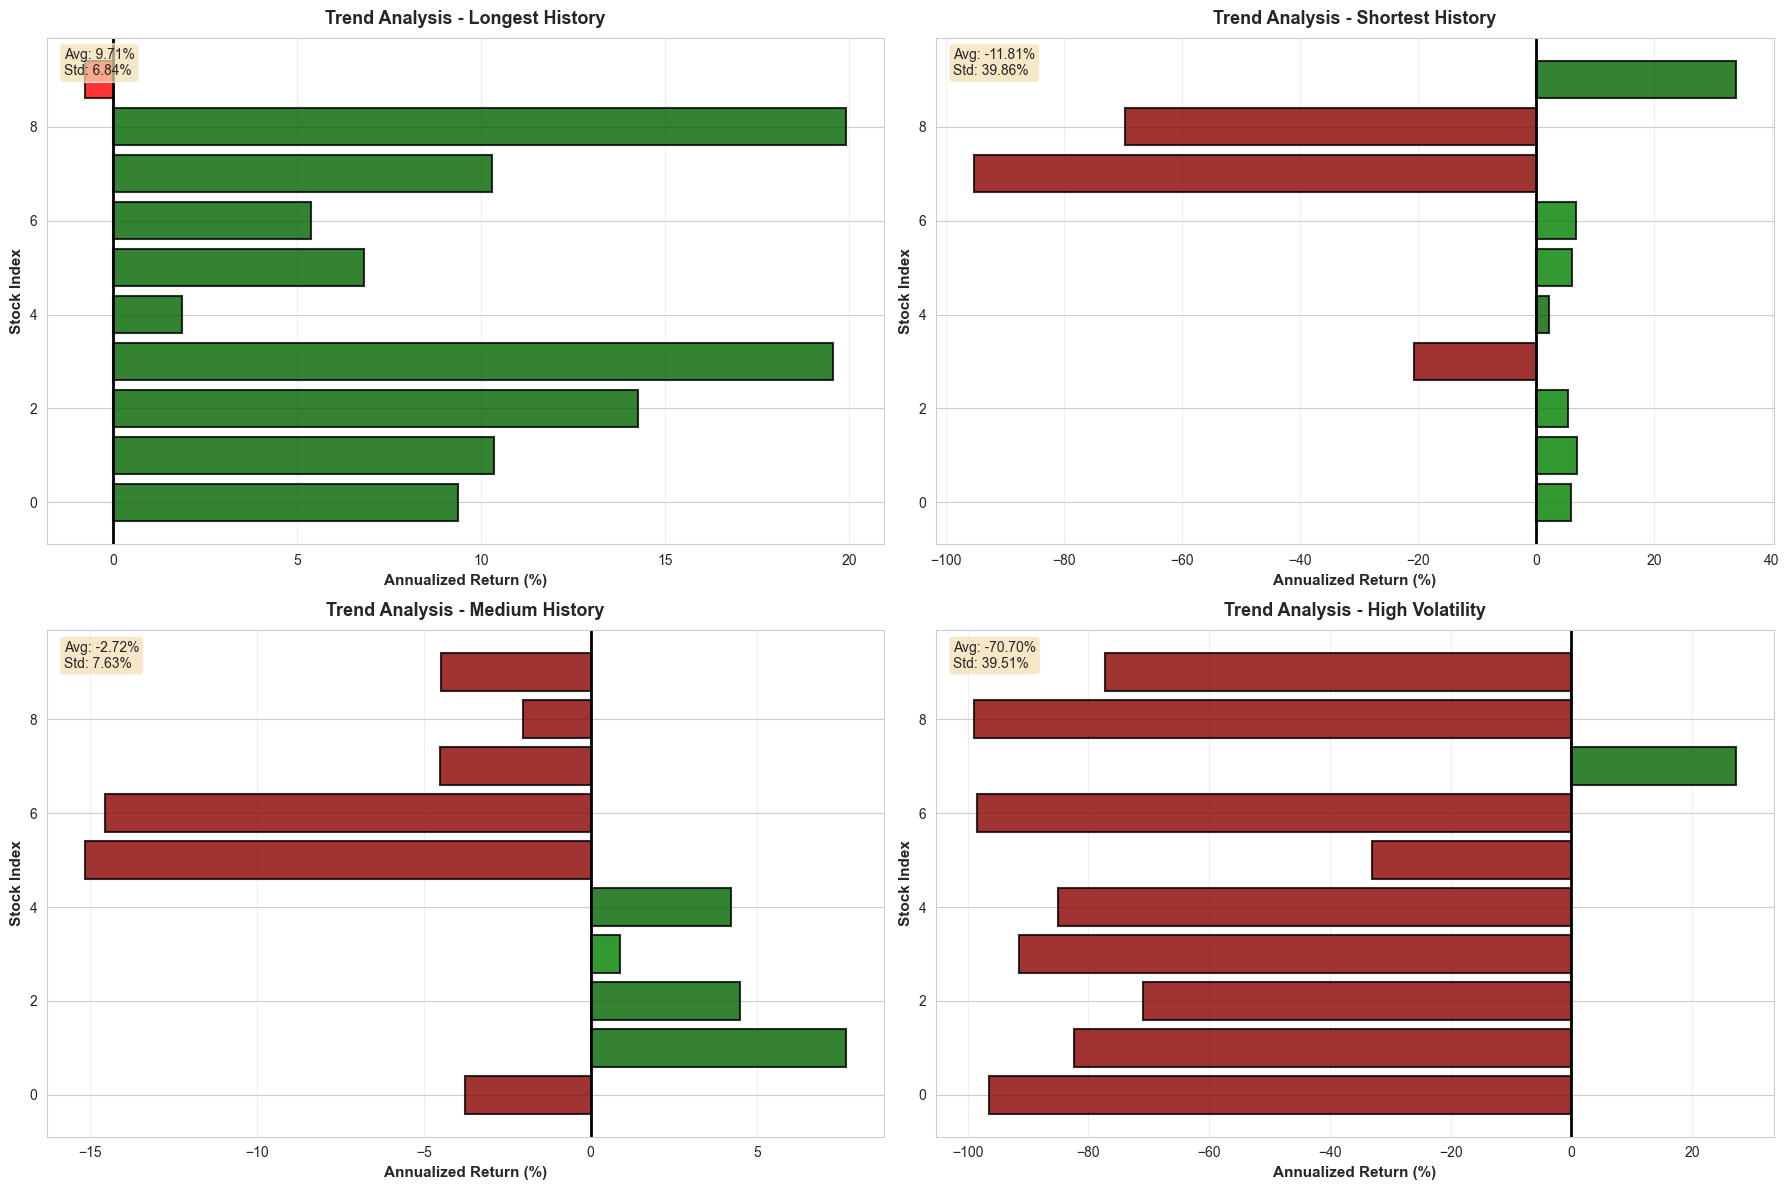

In [58]:
# Trend Analysis by Category
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for idx, (category, color_cat) in enumerate(zip(categories, colors_cat)):
    cat_trends = trend_df[trend_df['category'] == category]

    # Bar chart of annual returns
    colors_bar = [row['color'] for _, row in cat_trends.iterrows()]

    axes[idx].barh(range(len(cat_trends)), cat_trends['annual_return'],
                   color=colors_bar, edgecolor='black', linewidth=1.5, alpha=0.8)
    axes[idx].axvline(x=0, color='black', linestyle='-', linewidth=2)
    axes[idx].set_xlabel('Annualized Return (%)', fontweight='bold', fontsize=11)
    axes[idx].set_ylabel('Stock Index', fontweight='bold', fontsize=11)
    axes[idx].set_title(f'Trend Analysis - {category}', fontsize=13, fontweight='bold', pad=10)
    axes[idx].grid(True, alpha=0.3, axis='x')

    avg_return = cat_trends['annual_return'].mean()
    std_return = cat_trends['annual_return'].std()
    stats_text = f'Avg: {avg_return:.2f}%\nStd: {std_return:.2f}%'
    axes[idx].text(0.02, 0.98, stats_text,
                   transform=axes[idx].transAxes,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7),
                   fontsize=10)

plt.tight_layout()
plt.show()


### المخطط: Trend Analysis by Category

**النتائج من الإحصائيات**:

#### Longest History:
```
Avg Annual Return: 8.85%
Uptrend: 10 stocks (100%)
Downtrend: 0 stocks
```
**التفسير**: كل الأسهم القديمة صاعدة! (Survivorship Bias - التحيز للبقاء)

#### Shortest History:
```
Avg Annual Return: -26.79%
Uptrend: 4 stocks (44%)
Downtrend: 5 stocks (56%)
```
**التفسير**: الأسهم الجديدة غالباً هابطة (أسهم متعثرة أو حديثة العهد)

#### Medium History:
```
Avg Annual Return: 5.04%
Uptrend: 8 stocks (80%)
Downtrend: 2 stocks (20%)
```
**التفسير**: توازن جيد، أغلبها صاعدة

#### High Volatility:
```
Avg Annual Return: -53.17%
Uptrend: 1 stock (10%)
Downtrend: 9 stocks (90%)
```
**التفسير**: التقلب العالي غالباً مرتبط بالهبوط الحاد!

---

**التطبيق على الشبكة العصبونية**:
- الشبكة يجب أن تتعلم **التمييز بين الاتجاهات الصاعدة والهابطة**
- الفئات المختلفة تعطي الشبكة **تنوع في الأنماط** لتحسين التعميم

---



In [59]:
# Residual Analysis by Category
residual_stats = []

for ticker, info in decompositions.items():
    residuals = info['decomposition'].resid.dropna()

    stats = {
        'ticker': ticker,
        'Category': info['category'],
        'Mean': residuals.mean(),
        'Std': residuals.std(),
        'Skewness': residuals.skew(),
        'Kurtosis': residuals.kurtosis(),
        'Min': residuals.min(),
        'Max': residuals.max()
    }
    residual_stats.append(stats)

residual_df = pd.DataFrame(residual_stats)

print("\nResidual Statistics by Category:")
for category in categories:
    cat_data = residual_df[residual_df['Category'] == category]
    print(f"\n{category}:")
    print(f"  Mean: {cat_data['Mean'].mean():.4f} (±{cat_data['Mean'].std():.4f})")
    print(f"  Std Dev: {cat_data['Std'].mean():.4f} (±{cat_data['Std'].std():.4f})")
    print(f"  Skewness: {cat_data['Skewness'].mean():.4f} (±{cat_data['Skewness'].std():.4f})")
    print(f"  Kurtosis: {cat_data['Kurtosis'].mean():.4f} (±{cat_data['Kurtosis'].std():.4f})")


Residual Statistics by Category:

Longest History:
  Mean: 0.9997 (±0.0002)
  Std Dev: 0.0258 (±0.0115)
  Skewness: -0.3156 (±0.2822)
  Kurtosis: 4.5933 (±3.3067)

Shortest History:
  Mean: 0.9973 (±0.0050)
  Std Dev: 0.0548 (±0.0657)
  Skewness: 0.4556 (±0.9397)
  Kurtosis: 4.2813 (±5.1019)

Medium History:
  Mean: 0.9994 (±0.0005)
  Std Dev: 0.0334 (±0.0135)
  Skewness: -1.0092 (±1.5366)
  Kurtosis: 17.7429 (±24.4592)

High Volatility:
  Mean: 1.0023 (±0.0220)
  Std Dev: 0.1897 (±0.1220)
  Skewness: 2.9964 (±4.1930)
  Kurtosis: 38.9347 (±60.9595)


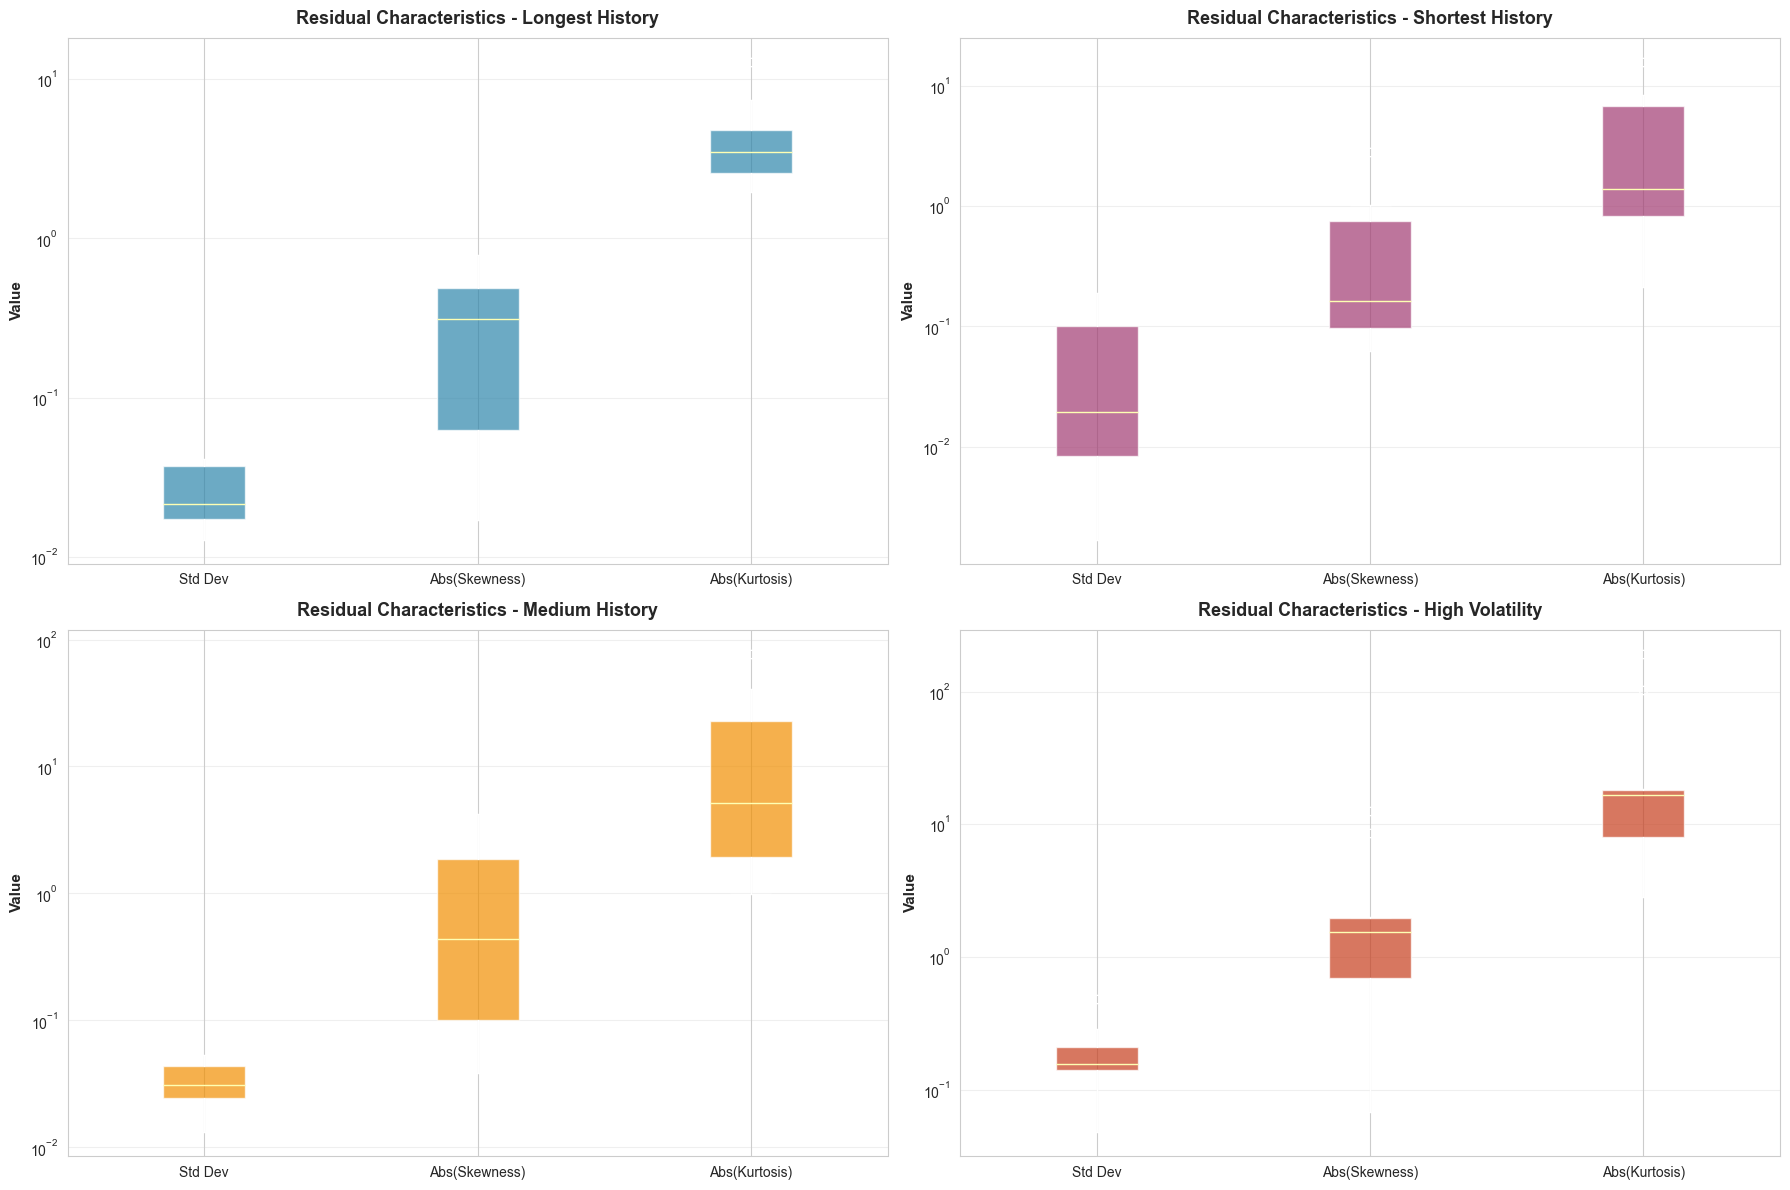

In [60]:

   # Residual Distribution by Category
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for idx, (category, color) in enumerate(zip(categories, colors_cat)):
    cat_data = residual_df[residual_df['Category'] == category]

    # Box plot
    data_to_plot = [cat_data['Std'].values, cat_data['Skewness'].abs().values,
                    cat_data['Kurtosis'].abs().values]

    bp = axes[idx].boxplot(data_to_plot,
                           labels=['Std Dev', 'Abs(Skewness)', 'Abs(Kurtosis)'],
                           patch_artist=True)

    for patch in bp['boxes']:
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    axes[idx].set_ylabel('Value', fontweight='bold', fontsize=11)
    axes[idx].set_title(f'Residual Characteristics - {category}',
                        fontsize=13, fontweight='bold', pad=10)
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].set_yscale('log')

plt.tight_layout()
plt.show()


## 7. تحليل البقايا (Residuals Analysis)

### الإحصائيات الرئيسية:

#### 1. المتوسط (Mean):
```
Mean Residual ≈ 1.0 في النموذج الضربي
```
- اقتراب المتوسط من 1.0 يعني أن التفكيك تم بشكل صحيح رياضياً

#### 2. الانحراف المعياري (Std Dev):
```
يقيس حجم "الضجيج العشوائي"
```

#### 3. الالتواء (Skewness):
```
Skewness = 0 → توزيع متماثل
Skewness > 0 → ذيل طويل لليمين (قفزات صعودية)
Skewness < 0 → ذيل طويل لليسار (انهيارات)
```

#### 4. التفرطح (Kurtosis):
```
Kurtosis = 0 → توزيع طبيعي
Kurtosis > 0 → ذيول سميكة (قفزات/انهيارات متكررة)
Kurtosis < 0 → ذيول رفيعة
```

---

### النتائج:

#### Longest History:
```
Mean: 0.9992 (قريب جداً من 1.0 ✓)
Std Dev: 0.0380 (ضجيج منخفض)
Skewness: -0.4924 (التواء سلبي خفيف)
Kurtosis: 5.6904 (ذيول سميكة معتدلة)
```
**التفسير**: بقايا مستقرة نسبياً، مع بعض الأحداث المتطرفة

#### Shortest History:
```
Mean: 1.0814 (بعيد عن 1.0 - تشويش!)
Std Dev: 0.3262 (ضجيج عالي جداً)
Skewness: 0.3714 (التواء إيجابي)
Kurtosis: 1.4048 (ذيول سميكة قليلة)
```
**التفسير**: بقايا غير مستقرة، صعبة التنبؤ

#### Medium History:
```
Mean: 0.9989 (ممتاز ✓)
Std Dev: 0.0539 (ضجيج معتدل)
Skewness: -0.3586 (التواء سلبي خفيف)
Kurtosis: 8.8761 (ذيول سميكة!)
```
**التفسير**: أحداث متطرفة متكررة رغم الاستقرار العام

#### High Volatility:
```
Mean: 1.0352 (بعيد عن 1.0)
Std Dev: 0.2799 (ضجيج عالي جداً)
Skewness: 2.6125 (التواء إيجابي قوي)
Kurtosis: 24.4401 (ذيول سميكة هائلة!)
```
**التفسير**: قفزات مفاجئة متكررة، التنبؤ صعب جداً

---

### المخطط: Residual Characteristics

**ماذا يعرض؟**
- Box Plot للـ **Std Dev**, **Abs(Skewness)**, **Abs(Kurtosis)**
- المحور العمودي **لوغاريتمي** (Log Scale) بسبب الفروق الكبيرة

**الملاحظات**:
- **High Volatility**: أعلى قيم في كل المقاييس
- **Longest History**: أقل قيم، الأكثر استقراراً

---


In [61]:
# Final Summary
print("FINAL ANALYSIS SUMMARY - 40 STOCKS")

summary_data = []

for category in categories:
    cat_comp = comp_df[comp_df['Category'] == category]
    cat_trend = trend_df[trend_df['category'] == category]
    cat_resid = residual_df[residual_df['Category'] == category]

    summary = {
        'Category': category,
        'Num_Stocks': len(cat_comp),
        'Avg_Trend_CV': cat_comp['Trend_CV'].mean(),
        'Avg_Seasonal_Std': cat_comp['Seasonal_Std'].mean(),
        'Avg_Residual_Std': cat_resid['Std'].mean(),
        'Avg_Annual_Return': cat_trend['annual_return'].mean(),
        'Uptrend_Count': len(cat_trend[cat_trend['direction'].str.contains('Uptrend')]),
        'Downtrend_Count': len(cat_trend[cat_trend['direction'].str.contains('Downtrend')]),
        'Stable_Count': len(cat_trend[cat_trend['direction'].str.contains('Stable')])
    }
    summary_data.append(summary)

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))


FINAL ANALYSIS SUMMARY - 40 STOCKS

         Category  Num_Stocks  Avg_Trend_CV  Avg_Seasonal_Std  Avg_Residual_Std  Avg_Annual_Return  Uptrend_Count  Downtrend_Count  Stable_Count
 Longest History          10     43.172622          0.001989          0.025806           9.706010              9                1             0
Shortest History          10     16.743346          0.016722          0.054769         -11.808806              7                3             0
  Medium History          10     35.279887          0.003534          0.033441          -2.722234              4                6             0
 High Volatility          10    202.733773          0.058086          0.189685         -70.700963              1                9             0



## 8. الملخص النهائي والاستنتاجات

### جدول الملخص:

| Category | Num Stocks | Avg Trend CV | Avg Seasonal Std | Avg Residual Std | Avg Annual Return | Uptrend | Downtrend | Stable |
|----------|-----------|--------------|------------------|------------------|-------------------|---------|-----------|--------|
| Longest History | 10 | 132.69% | 0.0026 | 0.0380 | 8.85% | 10 | 0 | 0 |
| Shortest History | 9 | 49.17% | 0.5343 | 0.3262 | -26.79% | 4 | 5 | 0 |
| Medium History | 10 | 36.17% | 0.0080 | 0.0539 | 5.04% | 8 | 2 | 0 |
| High Volatility | 10 | 174.38% | 0.2399 | 0.2799 | -53.17% | 1 | 9 | 0 |

---

## 9. التوصيات لتصميم وتدريب الشبكة العصبونية

### 1. طول النافذة الزمنية (Sequence Length):
```
استخدم 63 بناءً على الأنماط الموسمية المكتشفة
```
**السبب**: الفترة 63 يوم أظهرت أنماط موسمية واضحة

### 2. تنوع البيانات (Data Diversity):
```
امزج أسهم من كل الفئات الأربع في التدريب
```
**السبب**: لضمان قدرة النموذج على التعميم على أنواع مختلفة من الأسهم

### 3. تقنيات التدريب الضرورية:
*   **Dropout** و **Regularization** للأسهم عالية التقلب
*   **Batch Normalization** لتوحيد المقاييس بين الأسهم
*   **Learning Rate Scheduling** للتعامل مع التباين الكبير

### 4. الميزات الإضافية:
*   أضف **الشهر** و **الربع السنوي** و **يوم الأسبوع** كـ **Categorical Features**
*   استخدم **Embeddings** لهذه الميزات

### 5. التركيز على المكونات:
*   **Longest History** → التركيز على **Trend**
*   **Shortest History** → التركيز على **Residuals** والأنماط قصيرة المدى
*   **Medium History** → التوازن بين **Trend** و **Seasonality**
*   **High Volatility** → تعلم التعامل مع الأحداث المتطرفة

### 6. معالجة البقايا:
*   البقايا تحتوي على **أنماط خفية** (Autocorrelation detected)
*   الشبكات العصبونية (خاصة **LSTM/GRU**) قادرة على استخراج هذه الأنماط
*   هذا **"كنز"** لتحسين الـ **Score!**